# Evaluation of updated star plate scale on star positions / median star offsets

To confirm end-to-end success of the updated star plate scale, 1ks of 81 observations were run with the DS 10.8.1 aspect pipeline with the FDC file set to use the updated star plate scale. This notebook reviews the median star offsets and compares to the offsets using the flight CALDB plate scale.

The evaluation shows overall improvement. 


In [1]:
import os
from glob import glob
import numpy as np
import mica.vv
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.table import Table
import logging
from kadi import events
from Ska.engarchive import fetch_sci

In [2]:
logger = logging.getLogger('vv')

In [3]:
logger.setLevel(50)

In [4]:
obsdirs = glob("obs*/pipeline_out")

In [5]:
len(obsdirs)

81

Make a method to fetch the housing temperature for each processed observation.

In [6]:
def get_house_temp(obsid):
    ds = events.dwells.filter(obsid=obsid)
    start = ds[0].start
    stop = ds[len(ds) - 1].stop
    house = fetch_sci.Msidset(['AACH1T','AAOTALT','AAOTASMT'], start, stop, stat='5min')
    return np.mean([house['AACH1T'].vals.mean(),
                    house['AAOTALT'].vals.mean(),
                    house['AAOTASMT'].vals.mean()])

Run mica vv to calculate expected star positions and the median offset of the stars in each observation.  The following block runs the mica vv on the observations processed with the flight plate scale (which was rerun for all observations so all comparisons would be done with data processed with DS 10.8.1).

In [7]:
odys = []
odzs = []
oys = []
ozs = []
odrs = []
used_obsdirs = []
slots = []
house_temps = []
dirstr = 'orig'
for obsdir in obsdirs: 
    obsdir = os.path.abspath(obsdir)
    obspar = glob(os.path.join(obsdir, 'obspar', 'axaf*'))[0]
    if os.path.exists(os.path.join(obsdir, dirstr, 'out2')):
        vv_dir = os.path.join(obsdir, dirstr, 'out2')
    else:
        vv_dir = os.path.join(obsdir, dirstr, 'out1')
    try:
        vv = mica.vv.Obi(obspar, vv_dir)
    except IndexError:
        print(obsdir)
        continue
    else:
        house_temp = get_house_temp(int(vv.obspar['obs_id']))
        for slot in [3, 4, 5, 6, 7]:
            vv_slot = vv.slot_report[str(slot)]
            if ('type' not in vv_slot) or (vv_slot['type'] != 'GUIDE'):
                continue
            odys.append(vv_slot['dy_med'])
            odzs.append(vv_slot['dz_med'])
            odrs.append(vv_slot['dr_med'])
            oys.append(vv_slot['mean_y'] * 3600.)
            ozs.append(vv_slot['mean_z'] * 3600.)
            used_obsdirs.append(obsdir)
            slots.append(slot)
            house_temps.append(house_temp)
odys = np.array(odys)
odzs = np.array(odzs)
house_temps = np.array(house_temps)

Plot the direction and approximate magnitude of the star offsets.  The flight CALDB shows a max offset in this data set of ~0.73 arcsec.

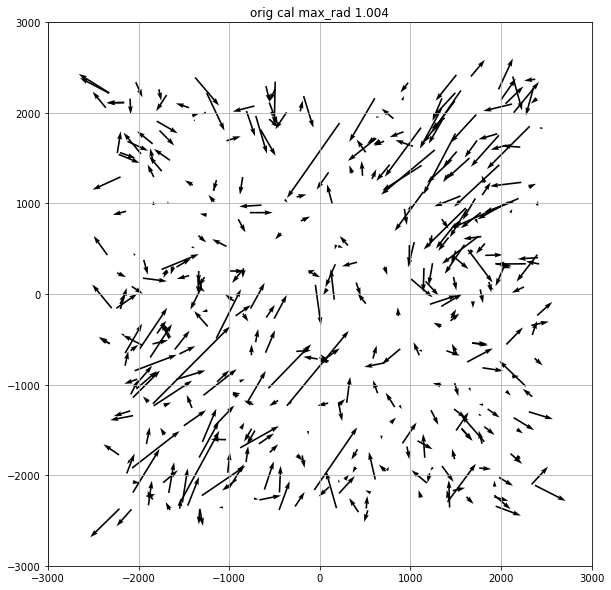

In [8]:
orads = np.sqrt(odys**2 + odzs**2)
omax_rad = np.max(orads)
fig = plt.figure(figsize=(10, 10))
plt.quiver(oys, ozs, odys, odzs, scale=5)
plt.title(f'orig cal max_rad {omax_rad:.03f}')
ax = fig.gca()
plt.xlim([-3000, 3000])
plt.ylim([-3000, 3000])
plt.grid()
ax.set_aspect('equal');

Run mica vv on the directories that have aspect solutions made with the updated star plate scale.

In [9]:
ndys = []
ndzs = []
ndrs = []
nys = []
nzs = []
dirstr = 'fids'
for obsdir in obsdirs:
    obsdir = os.path.abspath(obsdir)
    obspar = glob(os.path.join(obsdir, 'obspar', 'axaf*'))[0]
    if os.path.exists(os.path.join(obsdir, dirstr, 'out2')):
        vv_dir = os.path.join(obsdir, dirstr, 'out2')
    else:
        vv_dir = os.path.join(obsdir, dirstr, 'out1')
    try:
        vv = mica.vv.Obi(obspar, vv_dir)
    except IndexError:
        continue
    else:
        for slot in [3, 4, 5, 6, 7]:
            vv_slot = vv.slot_report[str(slot)]
            if ('type' not in vv_slot) or (vv_slot['type'] != 'GUIDE'):
                continue
            vv_slot = vv.slot_report[str(slot)]
            ndys.append(vv_slot['dy_med'])
            ndzs.append(vv_slot['dz_med'])
            ndrs.append(vv_slot['dr_med'])
            nys.append(vv_slot['mean_y'] * 3600.)
            nzs.append(vv_slot['mean_z'] * 3600.)
ndys = np.array(ndys)
ndzs = np.array(ndzs)

Plot the direction and approximate magnitude of the fid light offsets.  The flight CALDB shows a max offset in this data set of ~0.73 arcsec.

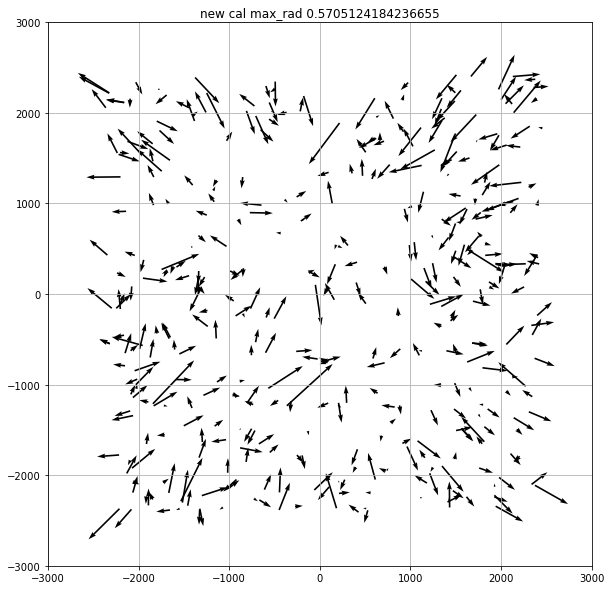

In [10]:
nrads = np.sqrt(ndys**2 + ndzs**2)
nmax_rad = np.max(nrads)
fig = plt.figure(figsize=(10, 10))
plt.quiver(nys, nzs, ndys, ndzs, scale=5)
plt.title(f'new cal max_rad {nmax_rad}')
ax = fig.gca()
plt.xlim([-3000, 3000])
plt.ylim([-3000, 3000])
plt.grid()
ax.set_aspect('equal');

Plot the star offsets from the flight and updated processings.  These are plotted on the same absolute scale.

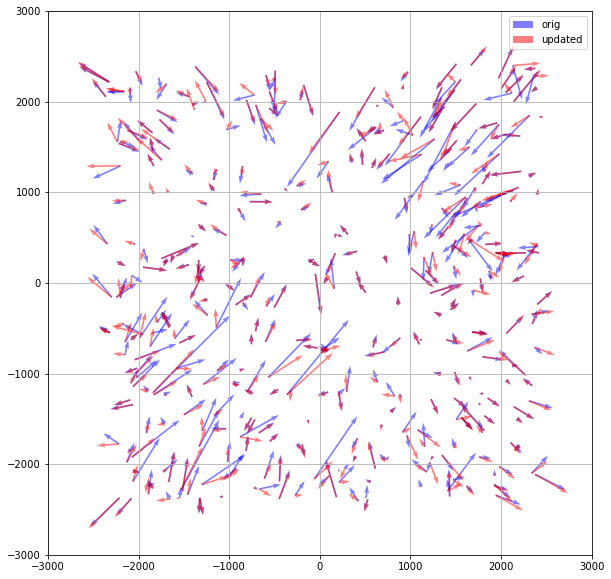

In [11]:
fig = plt.figure(figsize=(10, 10))
plt.quiver(oys, ozs, odys, odzs, color='blue', alpha=.5, scale=5, label='orig')
plt.quiver(nys, nzs, ndys, ndzs, color='red', alpha=.5, scale=5, label='updated')
ax = fig.gca()
plt.legend()
plt.xlim([-3000, 3000])
plt.ylim([-3000, 3000])
plt.grid()
ax.set_aspect('equal')

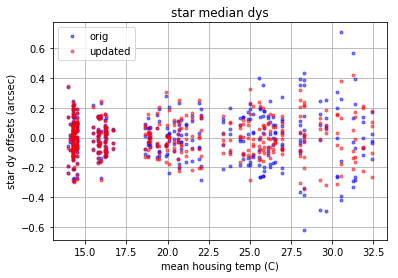

In [12]:
plt.plot(house_temps, odys, '.', color='blue', alpha=.5, label='orig')
plt.plot(house_temps, ndys, '.', color='red', alpha=.5, label='updated')
plt.grid()
plt.legend(loc='upper left')
plt.title('star median dys')
plt.ylabel('star dy offsets (arcsec)')
plt.xlabel('mean housing temp (C)');

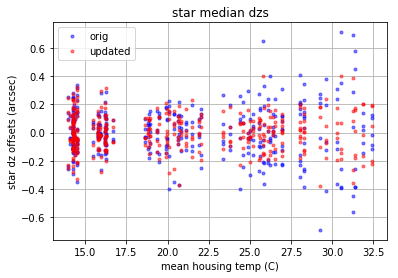

In [13]:
plt.plot(house_temps, odzs, '.', color='blue', alpha=.5, label='orig')
plt.plot(house_temps, ndzs, '.', color='red', alpha=.5, label='updated')
plt.legend(loc='upper left')
plt.title('star median dzs')
plt.ylabel('star dz offsets (arcsec)')
plt.xlabel('mean housing temp (C)')
plt.grid();

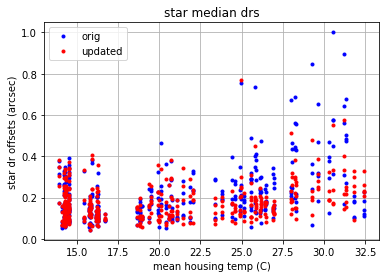

In [14]:
plt.plot(house_temps, odrs, '.', color='blue', label='orig')
plt.plot(house_temps, ndrs, '.', color='red', label='updated')
plt.ylabel('star dr offsets (arcsec)')
plt.title('star median drs')
plt.xlabel('mean housing temp (C)')
plt.grid()
plt.legend(loc='upper left');

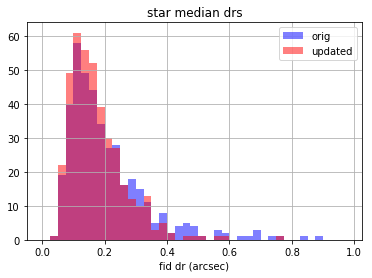

In [15]:
bins=np.arange(0, 1.0, 0.025)
plt.hist(odrs, bins=bins, color='blue', alpha=.5, label='orig')
plt.hist(ndrs, bins=bins, color='red', alpha=.5, label='updated');
plt.legend(loc='upper right')
plt.title('star median drs')
plt.xlabel('fid dr (arcsec)')
plt.grid()

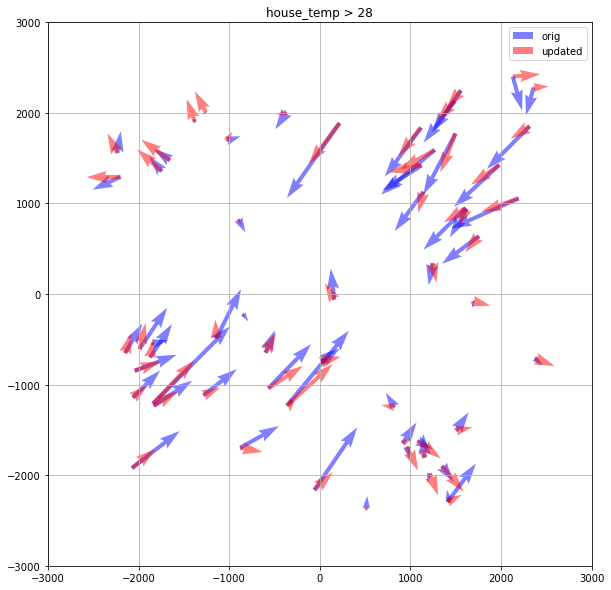

In [16]:
fig = plt.figure(figsize=(10, 10))
ok = house_temps > 27.5
oys = np.array(oys)
ozs = np.array(ozs)
nys = np.array(nys)
nzs = np.array(nzs)
plt.quiver(oys[ok], ozs[ok], odys[ok], odzs[ok], color='blue', alpha=.5, scale=5, label='orig')
plt.quiver(nys[ok], nzs[ok], ndys[ok], ndzs[ok], color='red', alpha=.5, scale=5, label='updated')
ax = fig.gca()
plt.legend()
plt.xlim([-3000, 3000])
plt.ylim([-3000, 3000])
plt.grid()
ax.set_aspect('equal')
plt.title('house_temp > 28');

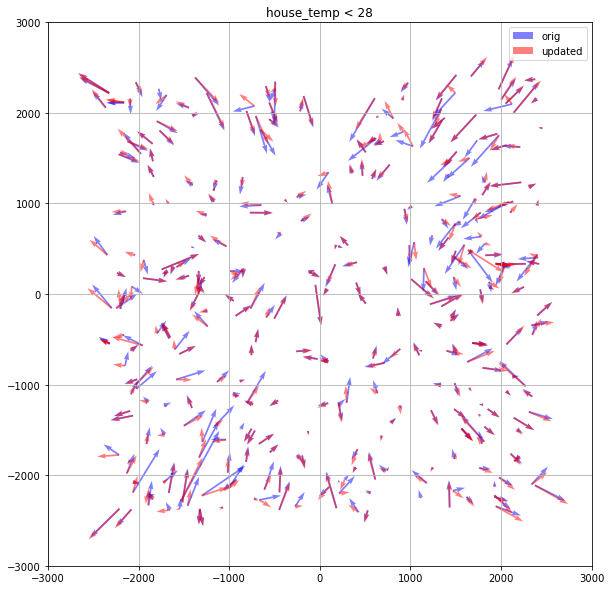

In [17]:
fig = plt.figure(figsize=(10, 10))
ok = house_temps < 27.5
oys = np.array(oys)
ozs = np.array(ozs)
nys = np.array(nys)
nzs = np.array(nzs)
plt.quiver(oys[ok], ozs[ok], odys[ok], odzs[ok], color='blue', alpha=.5, scale=5, label='orig')
plt.quiver(nys[ok], nzs[ok], ndys[ok], ndzs[ok], color='red', alpha=.5, scale=5, label='updated')
ax = fig.gca()
plt.legend()
plt.xlim([-3000, 3000])
plt.ylim([-3000, 3000])
plt.grid()
ax.set_aspect('equal')
plt.title('house_temp < 28');